Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Training a 3D ControlNet for Generating 3D Images Based on Input Masks 

![Generated image examples and input mask](https://developer.download.nvidia.com/assets/Clara/Images/monai_maisi_ct_generative_example_synthetic_data.png)

In this notebook, we detail the procedure for training a 3D ControlNet to generate high-dimensional 3D medical images. Due to the potential for out-of-memory issues on most GPUs when generating large images (e.g., those with dimensions of 512 x 512 x 512 or greater), we have structured the training process into two primary steps: 1) preparing training data, 2) training config preparation, and 3) launch training of 3D ControlNet. The subsequent sections will demonstrate the entire process using a simulated dataset. We also provide the real preprocessed dataset used in the finetuning config `environment_maisi_controlnet_train.json`. More instructions about how to preprocess real data can be found in the [README](./data/README.md) in `data` folder.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"

## Setup imports

In [1]:
import copy
import json
import os
import subprocess

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import create_test_image_3d
from scripts.diff_model_setting import setup_logging
from IPython.display import Image, display

print_config()

logger = setup_logging("notebook")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0rc12
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 76ef9f40c8da626928238c91eacddc789b0b4530
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.16.2
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Step 1: Training Data Preparation


### Simulate a special dataset

It is widely recognized that training AI models is a time-intensive process. In this instance, we will simulate a small dataset and conduct training over multiple epochs. While the performance may not reach optimal levels due to the abbreviated training duration, the entire pipeline will be completed within minutes.

`sim_datalist` provides the information of the simulated datasets. It lists 2 training images. The size of the dimension is defined by the `sim_dim`.

The diffusion model and ControlNet utilize a U-shaped convolutional neural network architecture, requiring matching input and output dimensions. Therefore, it is advisable to resample the input image dimensions to be multiples of 2 for compatibility. In this case, we have chosen dimensions that are multiples of 128.

The training workflow requires one JSON file to specify the image embedding and segmentation pairs. In addtional, the diffusion model used in ControlNet necessitates additional input attributes, including output dimension, output spacing, and top/bottom body region. The dimensions, and spacing can be extracted from the header information of the training images. The pseudo whole-body segmentation mask, and the top/bottom body region inputs can be determined through manual examination or by utilizing segmentation masks from tools such as [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) or [MONAI VISTA](https://github.com/Project-MONAI/VISTA). The body regions are formatted as 4-dimensional one-hot vectors: the head and neck region is represented by [1,0,0,0], the chest region by [0,1,0,0], the abdomen region by [0,0,1,0], and the lower body region (below the abdomen) by [0,0,0,1]. 

To train the ControlNet/diffusion unet, we first store the latent features (image embeddings) produced by the autoencoder's encoder in local storage. This allows the latent diffusion model to directly utilize these features, thereby conserving both time and GPU memory during the training process. Additionally, we have provided the script for multi-GPU processing to save latent features from all training images, significantly accelerating the creation of the entire training set. Please check the Step 1 Create Training Data in [maisi_diff_unet_training_tutorial](./maisi_diff_unet_training_tutorial.ipynb) and [diff_model_create_training_data.py](./scripts/diff_model_create_training_data.py) for how to encode images and save as image embeddings.

The JSON file used in ControlNet training has the following structure:

In [2]:
sim_dim = [256, 256, 128]
sim_datalist = {
    "training": [
        {
            "image": "tr_image_001_emb.nii.gz",  # relative path to the image embedding file
            # relative path to the combined label (pseudo whole-body segmentation mask + ROI mask) file
            "label": "tr_label_001.nii.gz",
            "fold": 0,  # fold index for cross validation, fold 0 is used for training
            "dim": sim_dim,  # the dimension of image
            "spacing": [1.5, 1.5, 1.5],  # the spacing of image
            "top_region_index": [0, 1, 0, 0],  # the top region index of the image
            "bottom_region_index": [0, 0, 0, 1],  # the bottom region index of the image
        },
        {
            "image": "tr_image_002_emb.nii.gz",
            "label": "tr_label_002.nii.gz",
            "fold": 1,
            "dim": sim_dim,
            "spacing": [1.5, 1.5, 1.5],
            "top_region_index": [0, 1, 0, 0],
            "bottom_region_index": [0, 0, 0, 1],
        },
        {
            "image": "tr_image_003_emb.nii.gz",
            "label": "tr_label_003.nii.gz",
            "fold": 1,
            "dim": sim_dim,
            "spacing": [1.5, 1.5, 1.5],
            "top_region_index": [0, 1, 0, 0],
            "bottom_region_index": [0, 0, 0, 1],
        },
    ]
}

### Generate simulated images and labels

Now we can use MONAI `create_test_image_3d` and `nib.Nifti1Image` functions to generate the 3D simulated images under the `work_dir`.

In [3]:
work_dir = "./temp_work_dir_controlnet_train_demo"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f, indent=4)

for d in sim_datalist["training"]:
    # The image embedding is downsampled twice by Autoencoder.
    img_emb, _ = create_test_image_3d(
        sim_dim[0] // 4,
        sim_dim[1] // 4,
        sim_dim[2] // 4,
        rad_max=10,
        num_seg_classes=1,
        random_state=np.random.RandomState(42),
    )
    # The label has a same shape as the original image.
    _, label = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )

    image_fpath = os.path.join(dataroot_dir, d["image"])
    # We repeat the volume 4 times to simulate the channel dimension of latent features.
    img_emb = np.stack([img_emb] * 4, axis=3)
    nib.save(nib.Nifti1Image(img_emb, affine=np.eye(4)), image_fpath)
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(label, affine=np.eye(4)), label_fpath)

logger.info("Generated simulated images.")
logger.info(f"img_emb shape: {img_emb.shape}")
logger.info(f"label shape: {label.shape}")

INFO:notebook:Generated simulated images.
INFO:notebook:img_emb shape: (64, 64, 32, 4)
INFO:notebook:label shape: (256, 256, 128)


## Step 2: Training Config Preparation

### Set up directories and configurations

To optimize the demonstration for time efficiency, we have adjusted the training epochs to 2. Additionally, we modified the `num_splits` parameter in [AutoencoderKlMaisi](https://github.com/Project-MONAI/MONAI/blob/dev/monai/apps/generation/maisi/networks/autoencoderkl_maisi.py#L881) from its default value of 16 to 4. This adjustment reduces the spatial splitting of feature maps in convolutions, which is particularly beneficial given the smaller input size. (This change helps convert convolutions to a for-loop based approach, thereby conserving GPU memory resources.)

In [4]:
env_config_path = "./configs/environment_maisi_controlnet_train.json"
train_config_path = "./configs/config_maisi_controlnet_train.json"
model_def_path = "./configs/config_maisi.json"

# Load environment configuration, model configuration and model definition
with open(env_config_path, "r") as f:
    env_config = json.load(f)

with open(train_config_path, "r") as f:
    train_config = json.load(f)

with open(model_def_path, "r") as f:
    model_def = json.load(f)

env_config_out = copy.deepcopy(env_config)
train_config_out = copy.deepcopy(train_config)
model_def_out = copy.deepcopy(model_def)

# Set up directories based on configurations
env_config_out["data_base_dir"] = dataroot_dir
env_config_out["json_data_list"] = datalist_file
env_config_out["model_dir"] = os.path.join(work_dir, env_config_out["model_dir"])
env_config_out["output_dir"] = os.path.join(work_dir, env_config_out["output_dir"])
env_config_out["tfevent_path"] = os.path.join(work_dir, env_config_out["tfevent_path"])
# We don't load pretrained checkpoints for demo
env_config_out["trained_autoencoder_path"] = None
env_config_out["trained_diffusion_path"] = None
env_config_out["trained_controlnet_path"] = None
env_config_out["exp_name"] = "tutorial_training_example"


# Create necessary directories
os.makedirs(env_config_out["model_dir"], exist_ok=True)
os.makedirs(env_config_out["output_dir"], exist_ok=True)
os.makedirs(env_config_out["tfevent_path"], exist_ok=True)

env_config_filepath = os.path.join(work_dir, "environment_maisi_controlnet_train.json")
with open(env_config_filepath, "w") as f:
    json.dump(env_config_out, f, sort_keys=True, indent=4)

# Update training configuration for demo
max_epochs = 2
train_config_out["controlnet_train"]["n_epochs"] = max_epochs
# We disable weighted_loss for dummy data, which is used to apply more penalty
# to the region of interest (e.g., tumors). When weighted_loss=1,
# we treat all regions equally in loss computation.
train_config_out["controlnet_train"]["weighted_loss"] = 1
# We also set weighted_loss_label to None, which indicates the list of label indices that
# we want to apply more penalty during training.
train_config_out["controlnet_train"]["weighted_loss_label"] = [None]
# We set it as a small number for demo
train_config_out["controlnet_infer"]["num_inference_steps"] = 1

train_config_filepath = os.path.join(work_dir, "config_maisi_controlnet_train.json")
with open(train_config_filepath, "w") as f:
    json.dump(train_config_out, f, sort_keys=True, indent=4)

# Update model definition for demo
model_def_out["autoencoder_def"]["num_splits"] = 4
model_def_filepath = os.path.join(work_dir, "config_maisi.json")
with open(model_def_filepath, "w") as f:
    json.dump(model_def_out, f, sort_keys=True, indent=4)

# Print files and folders under work_dir
logger.info(f"files and folders under work_dir: {os.listdir(work_dir)}.")

# Adjust based on the number of GPUs you want to use
num_gpus = 1
logger.info(f"number of GPUs: {num_gpus}.")

INFO:notebook:files and folders under work_dir: ['config_maisi.json', 'sim_dataroot', 'sim_datalist.json', 'models', 'outputs', 'environment_maisi_controlnet_train.json', 'config_maisi_controlnet_train.json'].
INFO:notebook:number of GPUs: 1.


In [5]:
def run_torchrun(module, module_args, num_gpus=1):
    # Define the arguments for torchrun
    num_nodes = 1

    # Build the torchrun command
    torchrun_command = [
        "torchrun",
        "--nproc_per_node",
        str(num_gpus),
        "--nnodes",
        str(num_nodes),
        "-m",
        module,
    ] + module_args

    # Set the OMP_NUM_THREADS environment variable
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = "1"

    # Execute the command
    process = subprocess.Popen(torchrun_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)

    # Print the output in real-time
    try:
        while True:
            output = process.stdout.readline()
            if output == "" and process.poll() is not None:
                break
            if output:
                print(output.strip())
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Capture and print any remaining output
        stdout, stderr = process.communicate()
        print(stdout)
        if stderr:
            print(stderr)
    return

## Step 3: Train the Model

After all latent feature/mask pairs have been created, we will initiate the multi-GPU script to train ControlNet.

The image generation process utilizes the [DDPM scheduler](https://arxiv.org/pdf/2006.11239) with 1,000 iterative steps. The ControlNet is optimized using L1 loss and a decayed learning rate scheduler. The batch size for this process is set to 1.

In [6]:
logger.info("Training the model...")

# Define the arguments for torchrun
module = "scripts.train_controlnet"
module_args = [
    "--environment-file",
    env_config_filepath,
    "--config-file",
    model_def_filepath,
    "--training-config",
    train_config_filepath,
]

run_torchrun(module, module_args, num_gpus=num_gpus)

INFO:notebook:Training the model...


2024-09-24 02:33:40,881 - INFO - 'dst' model updated: 158 of 206 variables.

INFO:maisi.controlnet.training:Number of GPUs: 2
INFO:maisi.controlnet.training:World_size: 1
INFO:maisi.controlnet.training:trained diffusion model is not loaded.
INFO:maisi.controlnet.training:set scale_factor -> 1.0.
INFO:maisi.controlnet.training:train controlnet model from scratch.
INFO:maisi.controlnet.training:total number of training steps: 4.0.
INFO:maisi.controlnet.training:
[Epoch 1/2] [Batch 1/2] [LR: 0.00000563] [loss: 0.7981] ETA: 0:00:01.501654 
INFO:maisi.controlnet.training:
[Epoch 1/2] [Batch 2/2] [LR: 0.00000250] [loss: 0.7976] ETA: 0:00:00 
INFO:maisi.controlnet.training:best loss -> 0.7978459596633911.
INFO:maisi.controlnet.training:
[Epoch 2/2] [Batch 1/2] [LR: 0.00000063] [loss: 0.7982] ETA: 0:00:01.988772 
INFO:maisi.controlnet.training:
[Epoch 2/2] [Batch 2/2] [LR: 0.00000000] [loss: 0.7998] ETA: 0:00:00 



## Step 4: Model Inference

Upon completing the training of the ControlNet, we can employ the multi-GPU script to perform inference. 
By integrating autoencoder, diffusion model, and controlnet, this process will generate 3D images with specified top/bottom body regions, spacing, and dimensions based on input masks.

In [7]:
logger.info("Inference...")

# Define the arguments for torchrun
module = "scripts.infer_controlnet"
module_args = [
    "--environment-file",
    env_config_filepath,
    "--config-file",
    model_def_filepath,
    "--training-config",
    train_config_filepath,
]

run_torchrun(module, module_args, num_gpus=num_gpus)

INFO:notebook:Inference...


2024-09-24 02:34:03,472 - INFO - 'dst' model updated: 158 of 206 variables.
2024-09-24 02:34:06,052 INFO image_writer.py:197 - writing: temp_work_dir_controlnet_train_demo/outputs/sample_20240924_023406_038072_image.nii.gz
2024-09-24 02:34:06,437 INFO image_writer.py:197 - writing: temp_work_dir_controlnet_train_demo/outputs/sample_20240924_023406_038072_label.nii.gz

INFO:maisi.controlnet.infer:Number of GPUs: 2
INFO:maisi.controlnet.infer:World_size: 1
INFO:maisi.controlnet.infer:trained autoencoder model is not loaded.
INFO:maisi.controlnet.infer:trained diffusion model is not loaded.
INFO:maisi.controlnet.infer:set scale_factor -> 1.0.
INFO:maisi.controlnet.infer:trained controlnet is not loaded.
INFO:root:`controllable_anatomy_size` is not provided.
INFO:root:---- Start generating latent features... ----

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]
INFO:root:---- Latent features generation time: 0.4557678699493408 

Upon completing the full training with actual CT datasets, users can expect output images similar to the examples below. Each sub-figure displays images generated by ControlNet, with synthetic tumors highlighted by overlaying tumor masks on top of the generated images. The real input condition of ControlNet consists of segmentation masks containing 127 anatomical structures. The specific output depends on the input segmentation mask. For a thorough evaluation of the entire volume, it is recommended to use visualization tools such as [ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php) or [3D Slicer](https://www.slicer.org/).

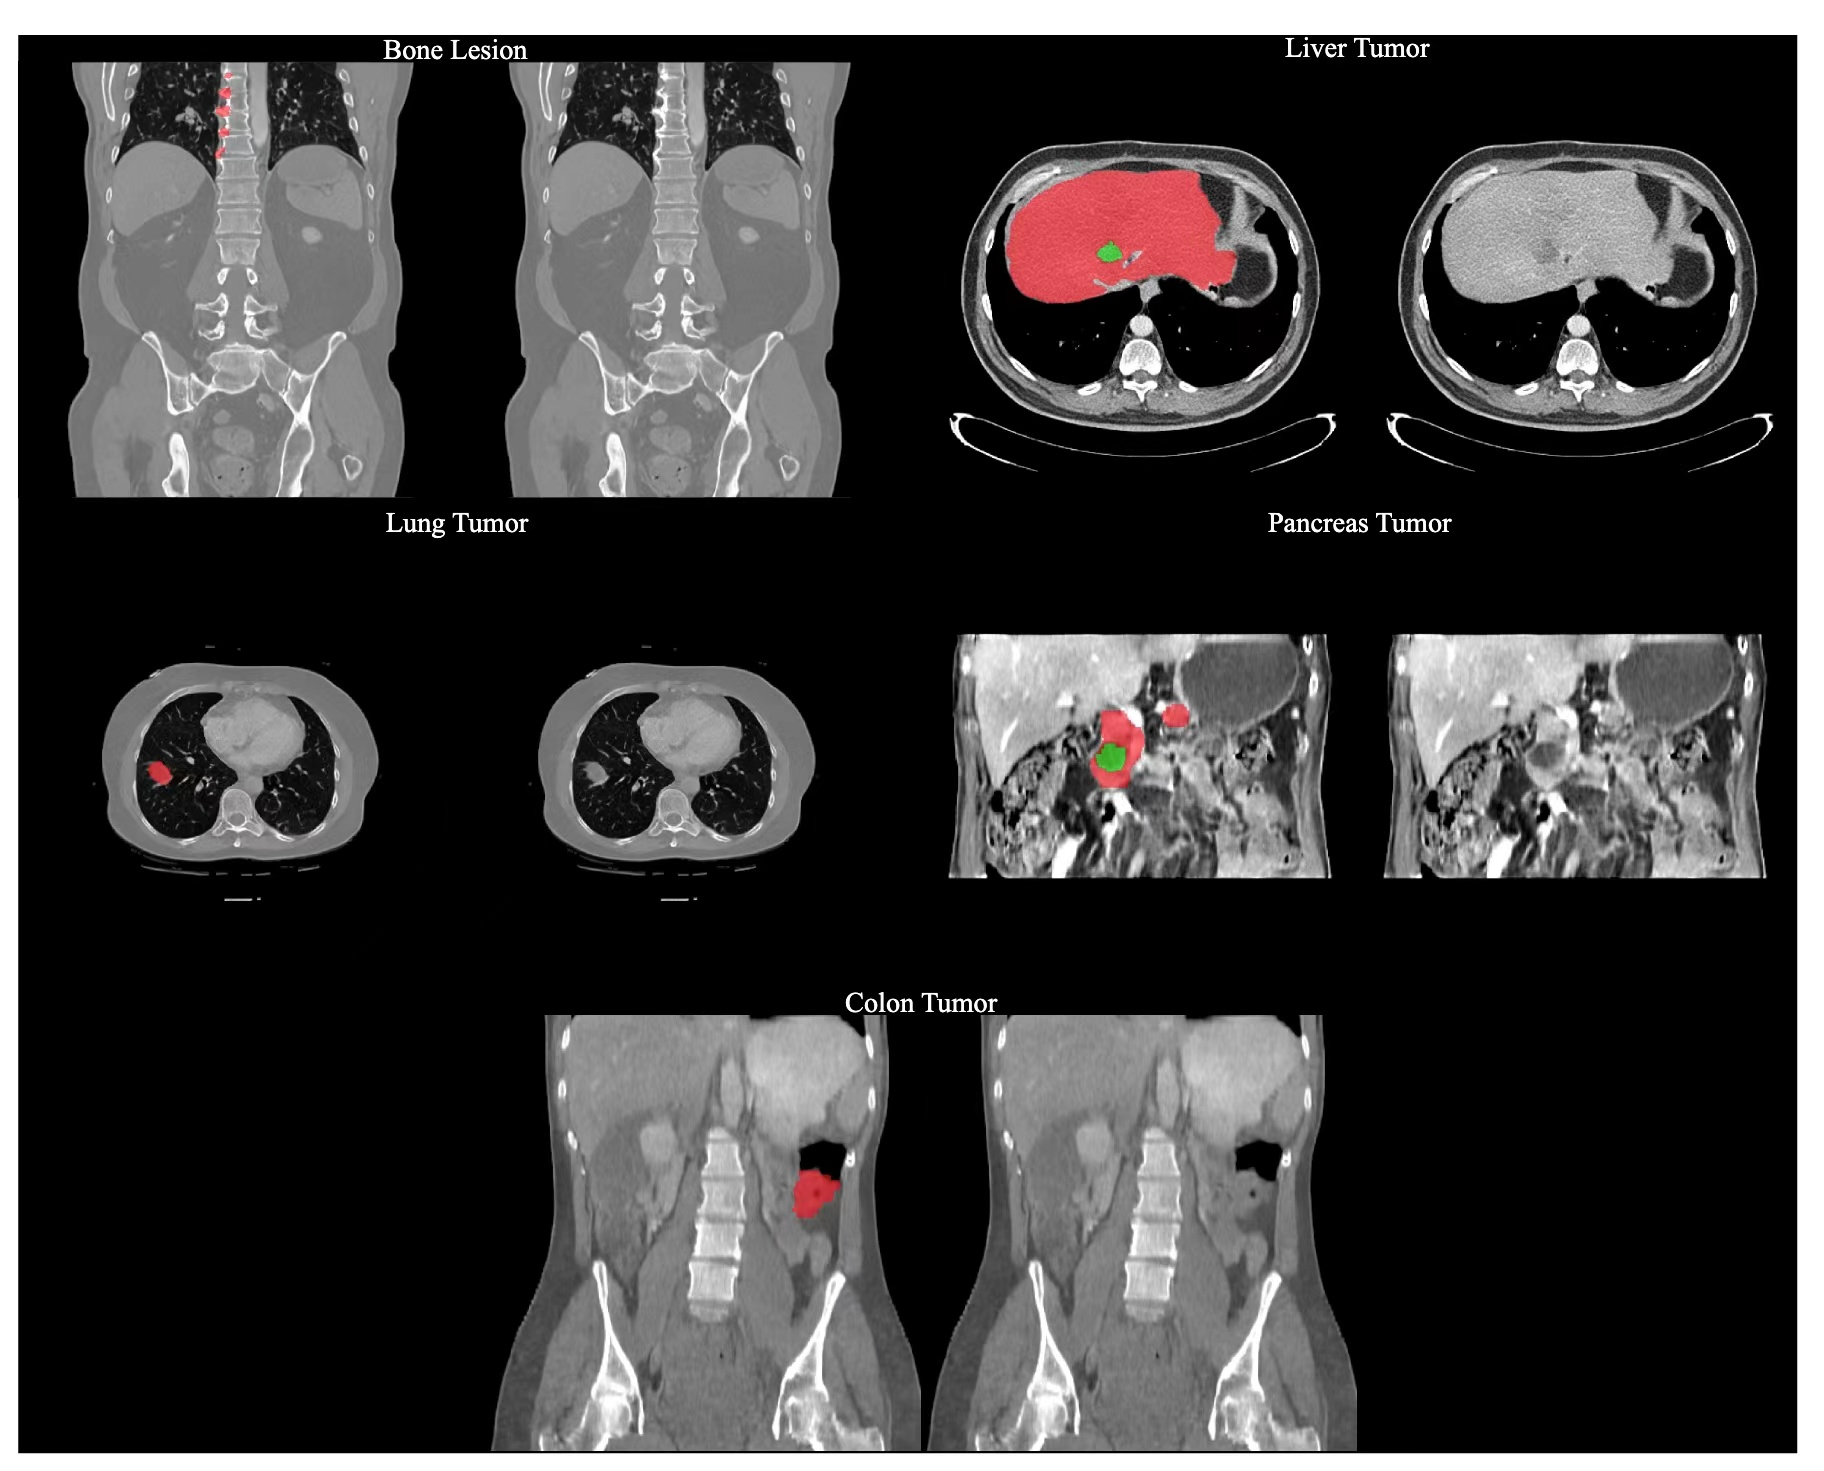

In [3]:
display(Image(filename="./figures/maisi_control-train-examples.png"))